In [1]:
import timeit
#importing datetime class  
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col

from tqdm.notebook import tqdm, trange
from math import comb
from pprint import pprint
from sympy.physics.matrices import msigma #imports Pauli matrices as sympy matrices
from scipy import sparse
from scipy.optimize import curve_fit

In [2]:
## Pauli matrices 
pi = np.pi
sx = sparse.csr_matrix(np.array([[0,1],[1,0]])).toarray()
sy = sparse.csr_matrix(np.array([[0,-1j],[1j,0]])).toarray()
sz = sparse.csr_matrix(np.array([[1,0],[0,-1]])).toarray()
im = sparse.csr_matrix(np.array([[1,0],[0,1]])).toarray()

### Functions

#### Hamiltonian-related

In [3]:
## Hamiltonian
def Ham(L,hlim,delta=1):
    #transverse spin-z contribution
    for i in range(1,L+1):  # indexing for consistency in manuscript
        h = 2*hlim*np.random.rand()-hlim  # disorder parameter h_i, different per site i
        # print('For site i=%i,h=%.3f.'%(i,h)) 
        if i==1:  # initializes, puts first sum as s_1^z x 1_2 x ...
            tzt = sz
        else:
            tzt = im
        for j in range(2,L+1):  # builds the term to the appropriate Hilbert space dim
            if i==j:
                tzt = sparse.kron(tzt,sz)
            else:
                tzt = sparse.kron(tzt,im)
        # print(tzt.toarray())
        if i==1:
            hz_trans = h*tzt
            # print('Current transverse contribution:','\n',hz_trans.toarray(),'\n')
        else:
            hz_trans += h*tzt
            # print('Current transverse contribution:','\n',hz_trans.toarray(),'\n')
    
    # nearest neighbors contribution
    for i in range(1,L+1): # periodic boundaries. for open, use range(1,L)
        if i==1 or i==L:  # remove i==L condition for open boundaries
            tx,ty,tz = sx,sy,sz
        else:
            tx,ty,tz = im,im,im
        for j in range(2,L+1): # periodic boundary conditions, runs until L
            if i==j or j==i+1: # if at the same site or at a neighboring site, add sigma-x, sigma-y, or sigma-z
                tx = sparse.kron(tx,sx)
                ty = sparse.kron(ty,sy)
                tz = sparse.kron(tz,sz)
            else:
                tx = sparse.kron(tx,im)
                ty = sparse.kron(ty,im)
                tz = sparse.kron(tz,im)
        # print('Sx for i=%i'%i,'\n',tx.toarray())
        # print('Sy for i=%i'%i,'\n',np.real(ty.toarray()))
        # print('Sz for i=%i'%i,'\n',tz.toarray())
        # print("\n")
        if i==1:  # creates starting sum
            hx = tx
            hy = ty
            hz = tz
        else:
            hx += tx
            hy += ty
            hz += tz
    # print(hz_trans.toarray())
    # print('spin-x NN contrib:','\n',hx.toarray(),'\n')
    # print('spin-y NN contrib:','\n',np.real(hy.toarray()),'\n')
    # print('spin-z NN contrib:','\n',hz.toarray(),'\n')
    # print('transverse z contrib:','\n',hz_trans.toarray(),'\n')
    return (hx+np.real(hy)+delta*hz) + hz_trans

### Matrix generators

## S^z operator
def SpinZ(L):
  for i in range(1,L+1):
    if i==1:
      tz = sz
    else:
      tz = im
    for j in range(2,L+1):
      if i==j:
        tz = sparse.kron(tz,sz)
      else:
        tz = sparse.kron(tz,im)
    if i==1:  
      spz = tz
    else:
      spz += tz
  return spz

## s^z at a single site 
def SpinZ_site(L,site):
  if site==1:
    tz = sz
  else:
    tz = im
  for j in range(2,L+1):
    if j==site:
      tz = sparse.kron(tz,sz)
    else:
      tz = sparse.kron(tz,im)
  return tz

## s^x at a single site
def SpinX_site(L,site):
  if site==1:
    tx = sx
  else:
    tx = im
  for j in range(2,L+1):
    if j==site:
      tx = sparse.kron(tx,sx)
    else:
      tx = sparse.kron(tx,im)
  return tx

## s^y at a single site
def SpinY_site(L,site):
  if site==1:
    ty = sy
  else:
    ty = im
  for j in range(2,L+1):
    if j==site:
      ty = sparse.kron(ty,sy)
    else:
      ty = sparse.kron(ty,im)
  return ty

## Obtains Hamiltonian block for a specific Sz value
def Hamblock(Hmat,Szmat,S_z=0):
  spinzmat_diag = np.array([Szmat[i,i] for i,val in enumerate(Szmat)])  # obtains 1D array of S_z eigenvalues ordered according to the basis
  
  # Indices of eigval array for the S_z value
  sz_index = np.where(spinzmat_diag==S_z)
  sz_index_col = sz_index[0]  # copy of the indices previously, with the proper array shape for filtering columns. problematic shaping, but a trivial matter 
  
  # Generates subspace matrix for a specific quantum number 
  hblock_row = Hmat[sz_index,:][0]    # obtains rows 
  hblock = hblock_row[:,sz_index_col] # filters the columns
  return hblock

#### Observables, matrix operations and statistics

In [4]:
## Matrix operations
# Expectation value of operator mat using vec basis
def expecval(basis,mat):
  A = np.dot(basis,mat)
  B = np.transpose(np.conj(basis))
  return np.dot(A,B)

# Similarity transformation using transmatrix U and target matrix A
def similtrans(U,A):
    Udag = np.transpose(np.conj(U))
    return Udag@A@U

# Obtains mean and variance of diagonal or off-diagonal elements of matrix A
# set delta_ij = 1 for diagonal mean and stdev, = 0 for off-diagonal
def matstats(A,delta_ij):
    if delta_ij==1:
        elem_filt = A[np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
        # print('The (mean,stdev) of the diagonal elements are:')
    else:
        elem_filt = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
        # print('The (mean,stdev) of the off-diagonal elements are:')
    return np.mean(elem_filt),np.var(elem_filt)

# Obtains element of an array closest to the value supplied
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Diagonalizes matrices using numpy linalg. Faster than scipy.sparse.linalg module
def eigensolver(HMat):
  # return sparse.linalg.eigs(HMat,k=len(HMat)-1) # slower than numpy
  return np.linalg.eigh(HMat)

### Functions for spectral density statistics 
## Poisson distribution
def dist_p(x):
  return np.exp(-x)

## Wigner-Dyson (WD) distribution
def dist_wd(x):
  return pi/2*x*np.exp(-pi/4*x**2)

## Obtains list of normalized level spacings from an (unordered) eigenvalue list
## Normalization factor = mean level spacing <e_(n+1)-e_n>
def dist_spacing(energies):
    N = len(energies)
    spacing_list = np.zeros(N-1) # N eigvals leads to N-1 adjacent spacings
    for i in range(N-1):
        spacing_list[i] = energies[i+1]-energies[i]
    return spacing_list/np.mean(spacing_list)

## Obtains list of inverse participation ratio IPR array of dim D from inputs of D eigenvectors of dim D
def IPR_array(vecset):
    ipr_list = []
    for vec in vecset:
        c2 = vec**2
        c4 = c2@c2
        ipr_list.append(1/c4)
    return ipr_list

# removes top q and bottom q percentiles of mat list 
def pctl_cutoff(mat,q):
    mlow = mat > np.percentile(mat,q)
    mhigh = mat < np.percentile(mat,100-q)
    return mat[mlow & mhigh]

# obtains IQR for an array for proper histogram binning
def IQRget(arr):
    return np.percentile(arr,75)-np.percentile(arr,25)

# Gaussian function for fitting
def gauss(x,mu,sig):
    D = sig*np.sqrt(2*pi)
    return 1/D * np.exp(-0.5*((x-mu)/sig)**2)

# Curve fitting for integrable level spacing
def w0_fitter(s,a,mu,sig):
    return a*dist_p(s) + (1-a)*gauss(s,mu,sig)

# Curve fitting for WD spacing
def wd_fitter(s,b,mu,sig):
    return b*dist_wd(s) + (1-b)*gauss(s,mu,sig)

#### Functions for realizations

In [5]:
## Calculates for the level spacing indicator given the eigenvalues
def lspacing_alpha(eigenvals):
    dist_data = dist_spacing(pctl_cutoff(eigenvals,5))

    nsamp = len(dist_data)
    bin_width = 2*IQRget(dist_data)/nsamp**(1/3.)
    Nbins = int((np.max(dist_data)-np.min(dist_data))//bin_width)
    pwdvals,bin_edges = np.histogram(dist_data,bins=Nbins,density=True)
    m = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(pwdvals)] # positions of bins a.k.a. comparison values m in discrete sum

    # calculates level spacing indicator alpha
    alfie = 0 # alpha variable
    alfie_norm = 0
    for k,pval in enumerate(pwdvals):
        alfie += np.abs(pval-dist_wd(m[k]))
        alfie_norm += dist_wd(m[k])
    return alfie/alfie_norm

## Calculates for the gap ratio given the inputs of the spacings s
# Output: gap ratio averaged over all spacings. Single value.
# evals should be an ordered list of the full eigenvalue spectrum. Clipping done inside function.
def gapratio(s):
    Ns = len(s)
    ratio_list = [min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(Ns-1)] # range(N_space-1) as there are N_space-1 ratios in the gaplist
    return np.average(ratio_list)

## Returns list of expectation values of szhalf as a function of energy
# eigstate list must be ordered by increasing corresponding eigval
# observable shape (N,N) must fit eigstate of dim N
def observable_expecval(eigstates,observable):
    expecval_list = []
    for k,vecl in enumerate(eigstates):
        expecval_list.append(expecval(vecl,observable))
    return expecval_list

## Returns ln of mean difference between local magnetizations of adjacent eigenstates
#  eval_array is the list of ordered eigenvalues same dimension for evec_array 
def meandiff(evec_array,observable):
    expecval_array = []
    Nval = len(evec_array)
    difflist = np.empty(Nval - 1) # N-1 differences
    for j,vec in enumerate(evec_array):
        expecval_array.append(np.real(expecval(vec,observable)))
    for i in range(Nval - 1):
        difflist[i] = np.abs(expecval_array[i+1] - expecval_array[i])
    return np.average(difflist)

### Realization runs

In [6]:
#getting today's date and saving in CurrentDate Variable 
# for naming realization runs 
now = datetime.now()
current_time = now.strftime("%m%d%H%M")
print("Current Time =", current_time)

Current Time = 08150952


In [8]:
## Realization functions
def Hamrun(L,h,delta=1,Szval=0):
    H = Ham(L,h,delta).toarray()
    Sz = SpinZ(L).toarray()
    H_sz0 = Hamblock(H,Sz,Szval)
    szhalf = Hamblock(SpinZ_site(L,L//2).toarray(),Sz,Szval)
    eigs = eigensolver(H_sz0)
    return eigs,szhalf

In [9]:
eigspec,szhalf = Hamrun(10,1e0)
# spacs = dist_spacing(evals)
# print(gapratio(spacs))
Nspec = len(eigspec[1])
print(len(eigspec[1]))
print(len(eigspec[1][Nspec//3:2*Nspec//3]))
expecval_list = observable_expecval(eigspec[1],szhalf)
# plt.plot(evals,expecval_list)
# plt.ylim(-0.5,0.5)
# plt.show()

252
84


In [10]:
(evals,evecs),szhalf = Hamrun(12,0) # structure is ((evals,evecs),szhalf)
meandiff(evecs[len(evecs)//3:2*len(evecs)//3],szhalf)

0.08560791462602542

In [71]:
L_rlztns = [14]
# h_rlztns = [0.1,0.5,1,2,2.7,3.6]
h_rlztns = [5,8]
# h_rlztns = [0]
rlztns = 40 # number of realizations

#### Realization gathering

In [72]:
llen = len(L_rlztns)
# llen = 4
hlen = len(h_rlztns)
gapratio_data = np.zeros((llen,hlen,2)) # (Llen x hlen x 2) array for each L, h, and (mean,stdev). ratio vs. h plots
alpha_data = np.zeros((llen,hlen,2))
mdiff_data = np.zeros((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots
Rab_data = np.zeros((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots

# for labeling
#getting today's date and saving in CurrentDate Variable 
now = datetime.now()
current_time = now.strftime("%m%d%H%M") # 08080334 -> aug 8, 3:34 am

for m,lval in enumerate(L_rlztns):
    for n,hval in tqdm(enumerate(h_rlztns)):
        start = timeit.default_timer()
        alpha_list = [] # level spacing indicator list 
        gapratio_list = [] # gap ratio list
        mdiff_list = [] # mean difference list 
#         Rab_list = [] # off-diagonal elements 
        for trials in range(rlztns):
            # data for each realization
            eigspec,szhalf = Hamrun(lval,hval)
            
            # level spacing indicator 
            alpha_list.append(lspacing_alpha(eigspec[0])) # eigspec[0] are the eigenvalues 
            # gap ratios
            spacs = dist_spacing(eigspec[0]) # eigspec[1] are the vectors
            gapratio_list.append(gapratio(spacs))
            
            # mean difference. follow discussion by Pal2010
            diff_list = []
            Nspec = len(eigspec[1])
            # eigvecs_clip = eigspec[1][Nspec//3:2*Nspec//3] # gets middle 1/3 of data. intensive for higher :
            eigvecs_clip = eigspec[1][Nspec//2-25:Nspec//2+25] # gets only the middle 50 states similar to Panda2019
            # eigvals_clip = eigspec[0][Nspec//2-25:Nspec//2+25]
            # meandiff(eigvecs_clip,szhalf)
            # exp_list = observable_expecval(eigvecs_clip,szhalf)
            mdiff_list.append(meandiff(eigvecs_clip,szhalf))

            # Follow Fig. 16 of D'Alessio 2016 for discussion of off-diagonal parts 
            # If I have enough time 
            
        # saving of data
        np.savetxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,current_time),alpha_list)
        # alpha_data[m][n][0] = np.average(alpha_list) # indices for alpha vs. W at diff L
        # alpha_data[m][n][1] = np.std(alpha_list)
        
        np.savetxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,current_time),gapratio_list)
        # gapratio_data[m][n][0] = np.average(gapratio_list) # indices for ratio vs. W at diff L
        # gapratio_data[m][n][1] = np.std(gapratio_list)
        
        np.savetxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,current_time),mdiff_list)
        # remove np.log if getting data from multiple files 
        # mdiff_data[n][m][0] = np.average(mdiff_list)  # NOTE: indices are REVERSED for meandiff vs. L at diff W
        # mdiff_data[n][m][1] = np.std(mdiff_list)
        
        # np.savetxt('Realizations/Rab_L%i_h%.2f_run%s'%(lval,hval,current_time),Rab_list)        
        # Rab_data[n][m][0] = np.average(Rab_list) # NOTE: indices are REVERSED for Rab vs. L at diff W
        # Rab_data[n][m][1] = np.std(Rab_list)
        stop = timeit.default_timer()
        print('Time: ', stop - start) 

0it [00:00, ?it/s]

Time:  5460.0488692
Time:  5424.323550499999


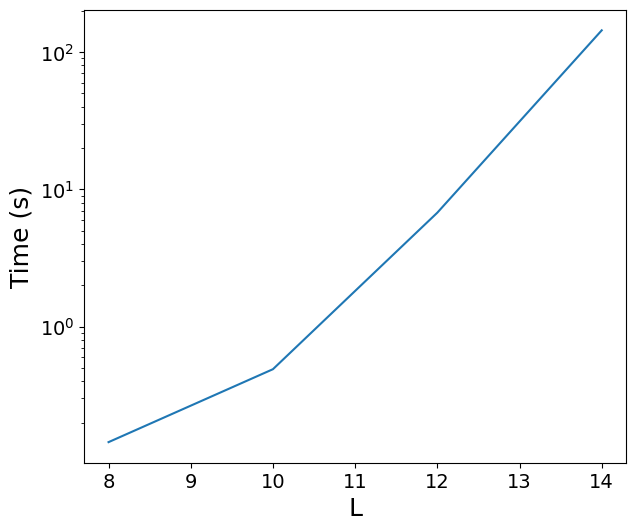

In [8]:
x = [8,10,12,14]
y = [0.14414,0.48983,6.7669,144.14]

ftimes = plt.figure(num=None, figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(x,y)
plt.ylabel('Time (s)',fontsize=18)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xticks(fontsize=14)
plt.xlabel(r'L',fontsize=18)
plt.savefig('Figures/runtimes.png',pad_inches=0,dpi=200)

In [157]:
evals = Hamrun(14,1e-7)[0][0] # structure is ((evals,evecs),szhalf)
spacs = dist_spacing(evals)
gapratio(spacs)

0.01611802248461602

In [155]:
gapratio_data

array([[nan,  0.]])

#### Combines results from different runs 

In [9]:
## Parameters 
L_rlztns = [8,10,12,14]
h_rlztns = [0.1,0.5,1,2,2.7,3.6]
llen = len(L_rlztns) # override. Make this 4
hlen = len(h_rlztns)

# runtimes that add different L 
runtimelist = ['08081703', '08081724'] # 10 runs, 990 runs
# runtimelist12 = ['08081703','08081724'] # 10 runs, 990 runs, uncomment if L12 runs are different from L8,L10
runtimelist14 = ['08081726','08082003','08091152','08091541','08091026','08091715'] # 10 runs, 10 runs, 10 runs, 10, 20, 40
runtimelisth0 = ['08091052'] # single W = 0 run 

# runtimes that add different W from [0.1,3.6]


## concatenates data from multiple runs

alpha_list = []
gapratio_list = []
mdiff_list = []

gapratio_data = np.empty((llen,hlen,2)) # (Llen x hlen x 2) array for each L, h, and (mean,stdev). ratio vs. h plots
alpha_data = np.empty((llen,hlen,2))
mdiff_data = np.empty((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots
Rab_data = np.empty((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots

# L_rlztns = [8,10,12,14]
for m,lval in enumerate(L_rlztns):
    for n,hval in tqdm(enumerate(h_rlztns)):
        alpha_list = []
        gapratio_list = []
        mdiff_list = []
        if m!=3: 
            for p,rval in enumerate(runtimelist):
                # loads list to concatenate
                alpha_add = np.loadtxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
                gapratio_add = np.loadtxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
                mdiff_add = np.loadtxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,rval))

                # appends values to existing list 
                alpha_list = alpha_list + alpha_add.tolist()
                gapratio_list = gapratio_list + gapratio_add.tolist()
                mdiff_list = mdiff_list + mdiff_add.tolist()
 
            alpha_data[m][n] = np.mean(alpha_list),np.std(alpha_list) # alpha vs. W
            gapratio_data[m][n] = np.mean(gapratio_list),np.std(gapratio_list) # r vs W.
            mdiff_data[n][m] = np.mean(mdiff_list),np.std(mdiff_list) # mdiff vs. L 
        
        else:
            for p,rval in enumerate(runtimelist14):
                # loads list to concatenate
                alpha_add = np.loadtxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
                gapratio_add = np.loadtxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
                mdiff_add = np.loadtxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,rval))

                # appends values to existing list 
                alpha_list = alpha_list + alpha_add.tolist()
                gapratio_list = gapratio_list + gapratio_add.tolist()
                mdiff_list = mdiff_list + mdiff_add.tolist()
 
            alpha_data[m][n] = np.mean(alpha_list),np.std(alpha_list)
            gapratio_data[m][n] = np.mean(gapratio_list),np.std(gapratio_list)
            mdiff_data[n][m] = np.mean(mdiff_list),np.std(mdiff_list)
        


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [1]:
# ## Parameters 
# L_rlztns = [8,10,12,14]
# h_rlztns = [0.1,0.5,1,2,2.7,3.6]
# llen = len(L_rlztns) # override. Make this 4
# hlen = len(h_rlztns)

# # runtimes that add different L 
# runtimelist = ['08081703', '08081724'] # 10 runs, 990 runs
# runtimelist12 = ['08081703','08081724'] # 10 runs, 990 runs 
# runtimelist14 = ['08081726','08082003','08091152','08091541','08091026','08091715'] # 10 runs, 10 runs, 10 runs, 10, 20, 40
# runtimelisth0 = ['08091052'] # single W = 0 run 

# # runtimes that add different W from [0.1,3.6]


# ## concatenates data from multiple runs

# alpha_list = []
# gapratio_list = []
# mdiff_list = []

# gapratio_data = np.empty((llen,hlen,2)) # (Llen x hlen x 2) array for each L, h, and (mean,stdev). ratio vs. h plots
# alpha_data = np.empty((llen,hlen,2))
# mdiff_data = np.empty((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots
# Rab_data = np.empty((hlen,llen,2)) # (hlen x llen x 2) array for mdiff vs. L plots

# L_rlztns = [8,10]
# for m,lval in enumerate(L_rlztns):
#     for n,hval in tqdm(enumerate(h_rlztns)):
#         alpha_list = []
#         gapratio_list = []
#         mdiff_list = []
#         for p,rval in enumerate(runtimelist):
#             # loads list to concatenate
#             alpha_add = np.loadtxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             gapratio_add = np.loadtxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             mdiff_add = np.loadtxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
            
#             # appends values to existing list 
#             alpha_list = alpha_list + alpha_add.tolist()
#             gapratio_list = gapratio_list + gapratio_add.tolist()
#             mdiff_list = mdiff_list + mdiff_add.tolist()
        
#         alpha_data[m][n] = np.mean(alpha_list),np.std(alpha_list)
#         gapratio_data[m][n] = np.mean(gapratio_list),np.std(gapratio_list)
#         mdiff_data[n][m] = np.mean(mdiff_list),np.std(mdiff_list)

# L_rlztns = [12]
# for m,lval in enumerate(L_rlztns):
#     for n,hval in tqdm(enumerate(h_rlztns)):
#         alpha_list = []
#         gapratio_list = []
#         mdiff_list = []
#         for p,rval in enumerate(runtimelist12):
#             alpha_add = np.loadtxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             gapratio_add = np.loadtxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             mdiff_add = np.loadtxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
            
#             alpha_list = alpha_list + alpha_add.tolist()
#             gapratio_list = gapratio_list + gapratio_add.tolist()
#             mdiff_list = mdiff_list + mdiff_add.tolist()
        
#         alpha_data[m+2][n] = np.mean(alpha_list),np.std(alpha_list)
#         gapratio_data[m+2][n] = np.mean(gapratio_list),np.std(gapratio_list)
#         mdiff_data[n][m+2] = np.mean(mdiff_list),np.std(mdiff_list)


# L_rlztns = [14]
# for m,lval in enumerate(L_rlztns): # L=8,10 runs 1 rlztn 08080852
#     for n,hval in tqdm(enumerate(h_rlztns)):
#         alpha_list = []
#         gapratio_list = []
#         mdiff_list = []
#         for p,rval in enumerate(runtimelist14):
#             alpha_add = np.loadtxt('Realizations/alpha_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             gapratio_add = np.loadtxt('Realizations/gapratio_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
#             mdiff_add = np.loadtxt('Realizations/mdiffnolog_L%i_h%.2f_run%s.dat'%(lval,hval,rval))
            
#             # if p ==0: # this part was added because the 08080852 run had only one element in the list 
#             #     alpha_list = alpha_list + [alpha_add.tolist()]
#             #     gapratio_list = gapratio_list + [gapratio_add.tolist()]
#             #     mdiff_list = mdiff_list + [mdiff_add.tolist()]
#             # else:
#             alpha_list = alpha_list + alpha_add.tolist()
#             gapratio_list = gapratio_list + gapratio_add.tolist()
#             mdiff_list = mdiff_list + mdiff_add.tolist()
        
#         alpha_data[m+3][n] = np.mean(alpha_list),np.std(alpha_list)
#         gapratio_data[m+3][n] = np.mean(gapratio_list),np.std(gapratio_list)
#         mdiff_data[n][m+3] = np.mean(mdiff_list),np.std(mdiff_list)

NameError: name 'np' is not defined

In [16]:
np.shape(alpha_list)

(20,)

#### Plots

In [282]:
gapratio_data

array([[[0.19163263, 0.01807365],
        [0.42947368, 0.03215787],
        [0.47405274, 0.04386892],
        [0.52150264, 0.03211524],
        [0.51881992, 0.04552286],
        [0.48733286, 0.0386948 ]],

       [[0.18963249, 0.04084142],
        [0.47017363, 0.02014779],
        [0.52636611, 0.02463047],
        [0.52810191, 0.02509752],
        [0.51206059, 0.00923674],
        [0.49031533, 0.03010413]],

       [[0.29555524, 0.02796301],
        [0.52638358, 0.01135674],
        [0.53074921, 0.00727027],
        [0.52795068, 0.00857481],
        [0.52524907, 0.01366002],
        [0.50364288, 0.02583181]]])

In [22]:
## alpha 
L_rlztns = [8,10,12,14]
mlist = ['o', 'v', 'X', 'D','s','p']
x = [0] + h_rlztns # adding 0 data to the level spacing 

falpha = plt.figure(num=None, figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
for i,ldata in enumerate(alpha_data):
    ydata = ldata.transpose()
    y,yerr = ydata
    
    # inserting 0 data, with 0 error bar
    y0 = np.loadtxt('Realizations/alpha_L%i_h0.00_run%s.dat'%(L_rlztns[i],runtimelisth0[0]))
    yerr0 = 0 
    y = np.insert(y,0,y0)
    yerr = np.insert(yerr,0,yerr0)
    
    plt.errorbar(x,y,yerr,color=cm.viridis(1-i/len(L_rlztns)),capsize=5)
    plt.scatter(x,y,label='L=%i'%L_rlztns[i],color=cm.viridis(1-i/len(L_rlztns)),marker=mlist[i])
plt.xlabel(r'$W$',fontsize=18)
# plt.xscale('log')
plt.ylabel(r'$\kappa$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvspan(0.5,1,color='blue',alpha=0.1)
plt.axvspan(1,2.7,color='blue',alpha=0.3)
# plt.axhline(y=0.53,xmin=0,ls='--',c='k')
# plt.legend(fontsize=12,loc='upper right')
# plt.savefig('Figures/levelspacing.png',pad_inches=0,dpi=200)

NameError: name 'h_rlztns' is not defined

In [20]:
gapratio_data

array([[[0.18866403, 0.02056787],
        [0.40095478, 0.04812712],
        [0.48466753, 0.04621881],
        [0.52175133, 0.0385118 ],
        [0.51375415, 0.03906848],
        [0.49688996, 0.04375765]],

       [[0.19695706, 0.02916338],
        [0.47882729, 0.03226511],
        [0.52141732, 0.02016449],
        [0.5264339 , 0.02060638],
        [0.51818083, 0.02225537],
        [0.49276368, 0.0293062 ]],

       [[0.29036676, 0.03436767],
        [0.51960593, 0.01197582],
        [0.52907148, 0.01021242],
        [0.52858085, 0.01005354],
        [0.52157407, 0.01268207],
        [0.4987848 , 0.02334478]],

       [[0.39260045, 0.03051949],
        [0.52800875, 0.00525108],
        [0.53068538, 0.00505473],
        [0.52955058, 0.0060361 ],
        [0.52579633, 0.0064491 ],
        [0.50686121, 0.0177145 ]]])

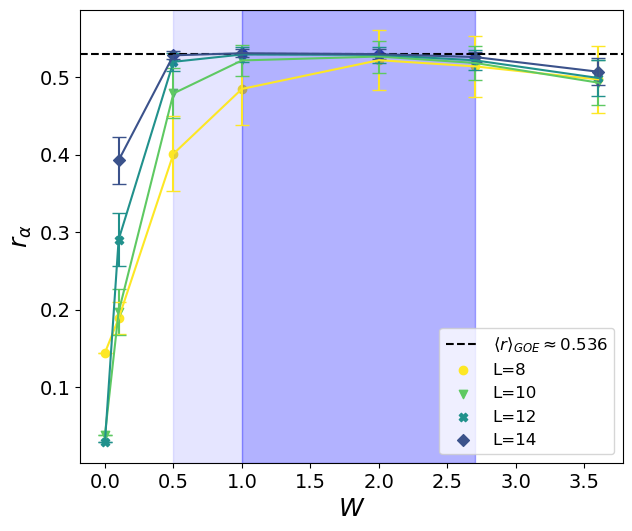

In [86]:
## gap ratio plot

fgap = plt.figure(num=None, figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
x = [0] + h_rlztns # adding 0 data to the gap ratio
for i,ldata in enumerate(gapratio_data):
    ydata = ldata.transpose()
    y,yerr = ydata
    
    # inserting 0 data, with 0 error bar
    y0 = np.loadtxt('Realizations/gapratio_L%i_h0.00_run%s.dat'%(L_rlztns[i],runtimelisth0[0]))
    yerr0 = 0 
    y = np.insert(y,0,y0)
    yerr = np.insert(yerr,0,yerr0)
    
    plt.errorbar(x,y,yerr,color=cm.viridis(1-i/len(L_rlztns)),capsize=5)
    plt.scatter(x,y,label='L=%i'%L_rlztns[i],color=cm.viridis(1-i/len(L_rlztns)),marker=mlist[i])
plt.xlabel(r'$W$',fontsize=18)
# plt.xscale('log')
plt.ylabel(r'$r_\alpha$',fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.axvspan(0.5,1,color='blue',alpha=0.1)
plt.axvspan(1,2.7,color='blue',alpha=0.3)
plt.axhline(y=0.53,xmin=0,ls='--',c='k',label=r'$\langle r \rangle_{GOE}\approx 0.536$')
plt.legend(fontsize=12)
plt.savefig('Figures/gapratio.png',pad_inches=0,dpi=200)

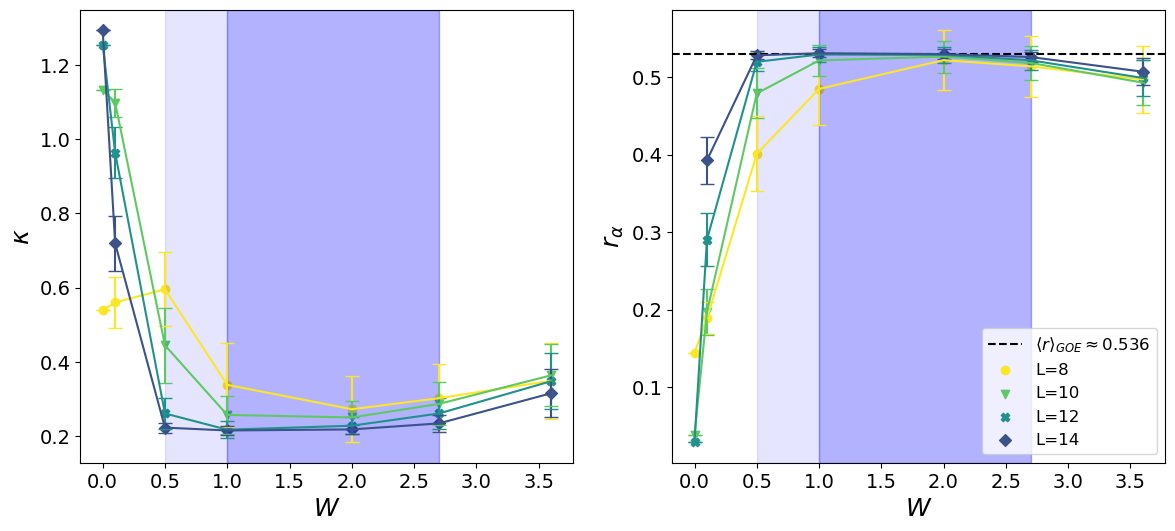

In [172]:
arfigs, araxes = plt.subplots(1,2,sharex=True,sharey=False,num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

x = [0] + h_rlztns # adding 0 data to the level spacing 

for i,ldata in enumerate(alpha_data):
    ydata = ldata.transpose()
    y,yerr = ydata
    
    # inserting 0 data, with 0 error bar
    y0 = np.loadtxt('Realizations/alpha_L%i_h0.00_run%s.dat'%(L_rlztns[i],runtimelisth0[0]))
    yerr0 = 0 
    y = np.insert(y,0,y0)
    yerr = np.insert(yerr,0,yerr0)
    
    araxes[0].errorbar(x,y,yerr,color=cm.viridis(1-i/len(L_rlztns)),capsize=5)
    araxes[0].scatter(x,y,label='L=%i'%L_rlztns[i],color=cm.viridis(1-i/len(L_rlztns)),marker=mlist[i])
araxes[0].set_xlabel(r'$W$',fontsize=18)
araxes[0].set_ylabel(r'$\kappa$',fontsize=18)
araxes[0].tick_params(axis='both', which='major', labelsize=14)   
araxes[0].axvspan(0.5,1,color='blue',alpha=0.1)
araxes[0].axvspan(1,2.7,color='blue',alpha=0.3)

for i,ldata in enumerate(gapratio_data):
    ydata = ldata.transpose()
    y,yerr = ydata
    
    # inserting 0 data, with 0 error bar
    y0 = np.loadtxt('Realizations/gapratio_L%i_h0.00_run%s.dat'%(L_rlztns[i],runtimelisth0[0]))
    yerr0 = 0 
    y = np.insert(y,0,y0)
    yerr = np.insert(yerr,0,yerr0)
    
    araxes[1].errorbar(x,y,yerr,color=cm.viridis(1-i/len(L_rlztns)),capsize=5)
    araxes[1].scatter(x,y,label='L=%i'%L_rlztns[i],color=cm.viridis(1-i/len(L_rlztns)),marker=mlist[i])
araxes[1].set_xlabel(r'$W$',fontsize=18)
araxes[1].set_ylabel(r'$r_\alpha$',fontsize=18)
araxes[1].tick_params(axis='both', which='major', labelsize=14)   
araxes[1].axvspan(0.5,1,color='blue',alpha=0.1)
araxes[1].axvspan(1,2.7,color='blue',alpha=0.3)
araxes[1].axhline(y=0.53,xmin=0,ls='--',c='k',label=r'$\langle r \rangle_{GOE}\approx 0.536$')
plt.legend(fontsize=12)

plt.savefig('Figures/indicator_gapratio.png',bbox_inches='tight',pad_inches=0.05,dpi=200)

In [ ]:
y = gapratio_data[:,0].transpose()[0]

In [59]:
(lambda x,a,b: a*np.exp(-b*x))(1,1,1)

0.36787944117144233

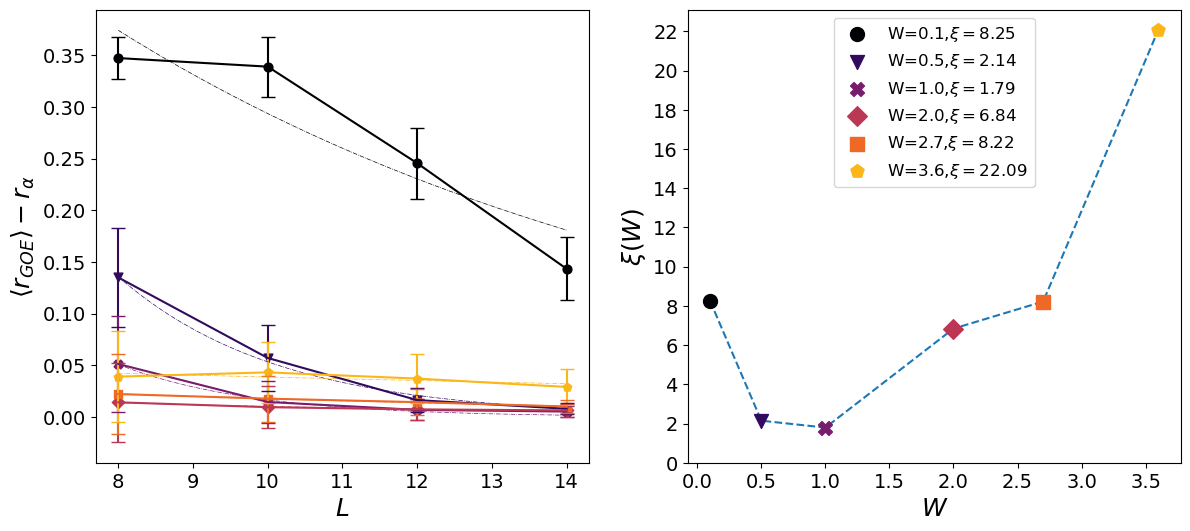

In [179]:
## Plots gap ratio vs. 

l = np.linspace(8,14,1000)
# fgapxi = plt.figure(num=None, figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
xifigs, xiaxes = plt.subplots(1,2,sharex=False,sharey=False,num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')
xidata = []
xierr = []

for i,hdata in enumerate(h_rlztns):
    ydata,yerr = gapratio_data[:,i].transpose()
    ydata = 0.536 - ydata
    xifit,xicov = curve_fit(lambda x,a,b: a*np.exp(b*x),L_rlztns,ydata)
    xidata.append(-1/xifit[1])
    # xierr.append(xidata[i]**(-2)*np.sqrt(xicov.flat[-1]))
    # print(xierr[i])
    xiaxes[0].plot(l,xifit[0]*np.exp(l*xifit[1]),color=cm.inferno(i/len(h_rlztns)),ls='-.',lw=0.5)
    xiaxes[0].errorbar(L_rlztns,ydata,yerr,color=cm.inferno(i/len(h_rlztns)),capsize=5)
    xiaxes[0].scatter(L_rlztns,ydata,label=r'W=%.1f,$\xi=%.2f$'%(hdata,-1/xifit[1]),color=cm.inferno(i/len(h_rlztns)),marker=mlist[i],s=40)
    
    xiaxes[1].scatter(hdata,xidata[i],color=cm.inferno(i/len(h_rlztns)),marker=mlist[i],s=100,label=r'W=%.1f,$\xi=%.2f$'%(hdata,-1/xifit[1]))
    # xiaxes[1].errorbar(hdata,xidata[i],color=cm.inferno(i/len(h_rlztns)),marker=mlist[i],capsize=500,fmt='none')
    
xiaxes[0].tick_params(axis='both', which='major', labelsize=14)    
xiaxes[0].set_xlabel(r'$L$',fontsize=18)
xiaxes[0].set_ylabel(r'$\langle r_{GOE}\rangle -r_\alpha$',fontsize=18)
xiaxes[1].legend(loc='upper center',fontsize=12)

xiaxes[1].plot(h_rlztns,xidata,zorder=0,ls='--')
xiaxes[1].set_yticks([i for i in np.arange(0,24,2)])
xiaxes[1].set_xlabel(r'$W$',fontsize=18)
xiaxes[1].set_ylabel(r'$\xi(W)$',fontsize=18)
xiaxes[1].tick_params(axis='both', which='major', labelsize=14)

# plt.ylabel(r'$r_{GOE}-r_\alpha$',fontsize=18)
# plt.xlabel(r'$L$',fontsize=18)
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
# plt.legend(fontsize=10)
plt.savefig('Figures/lengthscale.png',bbox_inches='tight',pad_inches=0.05,dpi=200)

In [134]:
xicov

array([[ 0.00042377, -0.00069615],
       [-0.00069615,  0.00119376]])

In [134]:
len(x0)

16

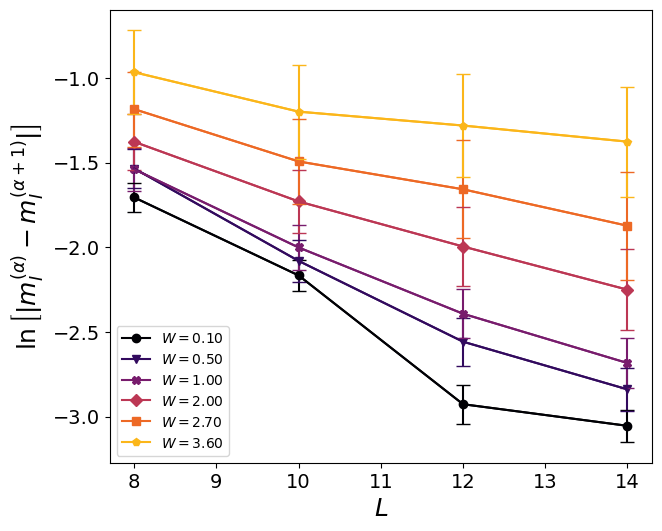

In [166]:
# mdiffh0 = []
# for i,lval in enumerate(L_rlztns):
#     hdata0 = np.loadtxt('Realizations/mdiffnolog_L%i_h0.00_run%s.dat'%(L_rlztns[i],runtimelisth0[0]))
#     mdiffh0.append(np.average(hdata0))
# x0 = np.asarray(mdiffh0)

# mdiff plot
L_rlztns = [8,10,12,14]
lmdiff = L_rlztns

mdfig, mdax = plt.subplots(1,1,num=None, figsize=(7, 6), dpi=100, facecolor='w', edgecolor='k')

# inserting W = 0 data
# mdax.plot(lmdiff,np.log(x0),label=r'$W=0.00$',ls='--',c='k')

for i,hdata in enumerate(mdiff_data):
    xdata = hdata.transpose()
    x,xerr = xdata
    y = np.log(x)
    ysigma = np.abs(1/x*xerr)
    mdax.errorbar(lmdiff,y,ysigma,color=cm.inferno(i/len(h_rlztns)),capsize=5)
    mdax.plot(lmdiff,y,marker=mlist[i],label=r'$W=%.2f$'%h_rlztns[i],color=cm.inferno(i/len(h_rlztns)))

mdax.set_xlabel(r'$L$',fontsize=18)
# mdax.set_setyticklabels(fontsize=14)
mdax.tick_params(axis='both', which='major', labelsize=14)
# plt.yscale('log')
mdax.set_ylabel(r'$\ln{\left[|m_I^{(\alpha)} - m_I^{(\alpha+1)}|\right]}$',fontsize=18)
# plt.axhline(y=0.53,xmin=0,ls='--',c='k')
mdax.legend(fontsize=10)
mdfig.savefig('Figures/mdiff.png',bbox_inches='tight',pad_inches=0.1,dpi=200)

### Hamiltonian tester

In [11]:
## Executes the code
## Parameters
L = 10     # chain length
h = 3.6   # disorder parameter
delta = 1   # anisotropy along z
Szval = 0   # total spin z 

np.set_printoptions(linewidth=200)
## Generates Hamiltonian and Spin-z matrices and converts to numpy array 
H = Ham(L,h,delta).toarray()
Sz = SpinZ(L).toarray()

## Generates the Hamiltonian and spin-z at L/2 
H_sz0 = Hamblock(H,Sz,Szval)
sxhalf = Hamblock(SpinX_site(L,L//2).toarray(),Sz,Szval)
syhalf = Hamblock(SpinY_site(L,L//2).toarray(),Sz,Szval)
szhalf = Hamblock(SpinZ_site(L,L//2).toarray(),Sz,Szval)

## Obtains eigenvalues and eigenvectors of full Hamiltonian 
eigvals,eigvecs = eigensolver(H_sz0)  # calculates the eigenvalues and eigenvectors of the matrix 

## Obtains expectation value of spin operator at site L/2
# expecval_list = []
# for i,vec in enumerate(eigvecs):
#   expecval_list.append(np.real(expecval(vec,syhalf))/L)

Average IPR for h=3.60 is:13.086


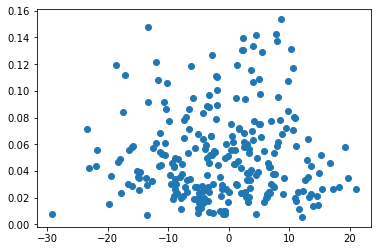

In [18]:
IPR_set = IPR_array(eigvecs)
IPR_set_norm = np.asarray(IPR_set)/len(eigvals)
print('Average IPR for h=%.2f is:%.3f'%(h,np.mean(IPR_set)))
plt.scatter(eigvals,IPR_set_norm)
# plt.ylim(0,400)


In [ ]:
### Testers
np.set_printoptions(linewidth=200)
print('For L=%i,h=%.2f'%(L,h),'\n\n Hamiltonian full spectrum \n',H,'\n\n Total Sz operator full spec. \n',Sz,'\n\n Hamiltonian S^z=%i subspace \n'%Szval,H_sz0)
print('\n s^z at site L/2 full spec.\n',SpinZ_site(L,L//2).toarray())
print('\n s^z at site L/2 S^z=%i subspace\n'%Szval,szhalf)
# print('Sample eigenvector is:',eigvecs[0],'a^2 + b^2 = %.3f + %.3f = %.3f'%(eigvecs[0][0]**2,eigvecs[0][1]**2,eigvecs[0][0]**2+eigvecs[0][1]**2))
# print(eigvecs)

For L=2,h=0.00 

 Hamiltonian full spectrum 
 [[ 2.  0.  0.  0.]
 [ 0. -2.  4.  0.]
 [ 0.  4. -2.  0.]
 [ 0.  0.  0.  2.]] 

 Total Sz operator full spec. 
 [[ 2  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0 -2]] 

 Hamiltonian S^z=0 subspace 
 [[-2.  4.]
 [ 4. -2.]]

 s^z at site L/2 full spec.
 [[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]

 s^z at site L/2 S^z=0 subspace
 [[ 1  0]
 [ 0 -1]]


### Single Run Implementations

In [11]:
## Executes the code
## Parameters
L = 12     # chain length
h = 0.1      # disorder parameter
delta = 1   # anisotropy along z
Szval = 0   # total spin z 

## Generates Hamiltonian and Spin-z matrices and converts to numpy array 
H = Ham(L,h,delta).toarray()
Sz = SpinZ(L).toarray()

## Generates the Hamiltonian and spin-z at L/2 
H_sz0 = Hamblock(H,Sz,Szval)
szhalf = Hamblock(SpinZ_site(L,L//2).toarray(),Sz,Szval)

In [12]:
## Obtains eigenvalues and eigenvectors of full Hamiltonian 
eigvals,eigvecs = eigensolver(H_sz0)  # calculates the eigenvalues and eigenvectors of the matrix 

## Obtains expectation value of spin-z operator at site L/2
expecval_list = []
for i,vec in enumerate(eigvecs):
  expecval_list.append(np.real(expecval(vec,szhalf))/L)
# print(expecval_list)

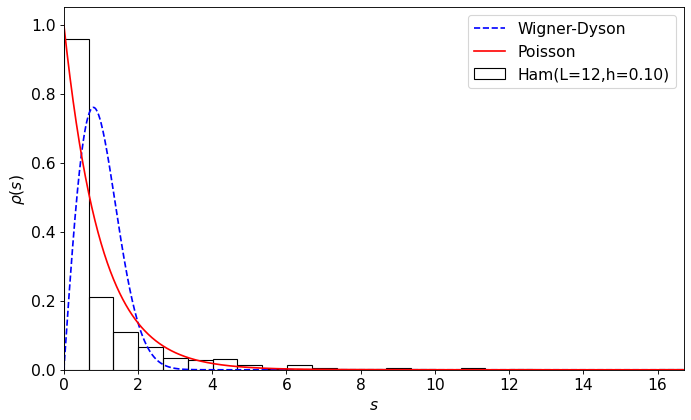

In [14]:
## Clips eigenvalue list at the lower and upper 5th percentiles
eigvals_clip = pctl_cutoff(eigvals,5)

## Obtains normalized mean level spacings of spectrum
rho_goe = dist_spacing(eigvals_clip)

## Cuts off spacings at the lower and upper 5th percentiles 

## Plots spacings of Ham eigvals
## Compares to plot of Poisson and WD dists
bin_width = 1 # number of bins
counts,bin_edges = np.histogram(rho_goe,bins=Nbins)
bin_spots = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(counts)]
Nbins = (np.max(rho_goe)-np.min(rho_goe))/bin_width
            
f0 = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
s0 = np.linspace(0,max(rho_goe),1000)
plt.hist(rho_goe,density=True,label='Ham(L=%i,h=%.2f)'%(L,h),bins=25,fill=False) # Why is this not returning a normalized hist?
# plt.bar(bin_spots,counts/(np.sum(counts)*bin_width),width=0.3,fill=False)
plt.plot(s0,dist_wd(s0),c='b',ls='--',label='Wigner-Dyson')
plt.plot(s0,dist_p(s0),c='r',ls='-',label='Poisson')
plt.xlim(0,max(rho_goe))
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel(r'$\rho(s)$',fontsize='14')
plt.xlabel(r'$s$',fontsize='14')
plt.legend(fontsize='14')
# plt.savefig('Figures/p_wd_l%i_h%.1e.png'%(L,h))

Variance of diagonal elements is 1.698e-02, off-diagonal elements is 1.065e-03.


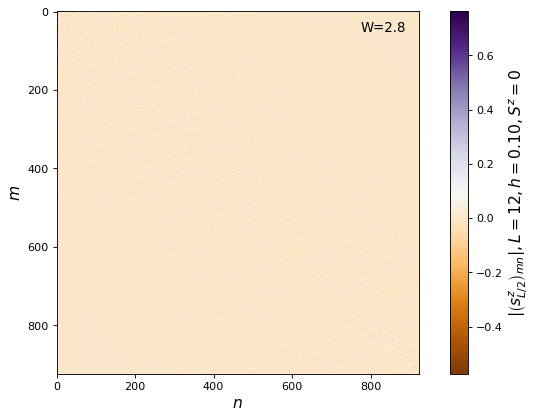

In [ ]:
## Plots the matrix elements for the spin-z at L/2 operator

pic = similtrans(eigvecs,szhalf) # absolute value of s_i^z in eigenbasis
diagmean = np.mean(pic.diagonal())
diagstd = np.sqrt(np.var(pic.diagonal()))

f1 = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(pic,cmap='PuOr')
plt.text(775,50,'W=2.8',fontsize=12)
# plt.imshow(pic,vmin=np.amin(pic),vmax=diagmean+diagstd,cmap='gray') # max value is diagonal mean + 1 std
plt.xlabel(r'$n$',fontsize=14)
plt.ylabel(r'$m$',fontsize=14)
cbar = plt.colorbar()
# cbar = plt.colorbar(location='top',orientation='horizontal',ticks=[0,diagmean,diagmean+diagstd])
# cbar = plt.colorbar(location='top',orientation='horizontal',ticks=[0,diagmean,diagmean+diagstd],fraction=0.046, pad=0.04)
# cbar.ax.set_yticklabels(['0', '%.2f'%diagmean, '>%.2f'%(diagmean+diagstd)])  # actual tick values
# cbar.ax.set_xticklabels([r'$\pi$', r'$\mu_\lambda$', r'$(\mu+\sigma)_\lambda$'])  # symbolic ticks
# cbar.ax.set_xticklabels([r'$0$', r'$\mu_\lambda=$%.2f'%diagmean, r'$\mu_\lambda+\sigma=$%.2f'%(diagmean+diagstd)])  # 'symbolic = actual'
cbar.set_label(r'$|\left(s_{L/2}^z\right)_{mn}|,L=%i,h=%.2f,S^z=%i$'%(L,h,Szval),fontsize='14')
# plt.savefig('Figures/szhalf_mat_L%i_h%.2f_Sz%i.png'%(L,h,Szval))


print('Variance of diagonal elements is %.3e, off-diagonal elements is %.3e.'%(matstats(pic,1)[1],matstats(pic,0)[1]))

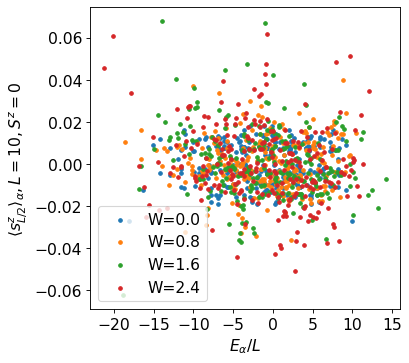

In [ ]:
## Plots expectation value of spinz at site L/2 for different L sizes
# L = 10
hlist_hvar = [i for i in np.arange(0,3.2,0.8)]
szhalf_filelist_hvar = []
eval_filelist_hvar = []
for i in range(len(hlist)):
    szhalf_filelist_hvar.append('Data/expec_spin_z_half_L%i_h%.2f_Sz%i.dat'%(L,hlist[i],Szval))
    eval_filelist_hvar.append('Data/eval_L%i_h%.2f_Sz%i.dat'%(L,hlist[i],Szval))
f3 = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

for i,ll in enumerate(szhalf_filelist_hvar):    
    x = np.loadtxt(eval_filelist_hvar[i])
    y = np.loadtxt(szhalf_filelist_hvar[i])
    plt.scatter(x,y,label='W=%.1f'%hlist[i],s=10)

# plt.scatter(eigvals,expecval_list,label='L=%i,h=%.3f'%(L,h))
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel(r'$\langle s_{L/2}^z \rangle_{\alpha},L=%i,S^z=%i$'%(L,Szval),fontsize='14')
plt.xlabel(r'$E_\alpha/L$',fontsize='14')
plt.legend(fontsize='14')
# plt.savefig('Figures/shalf_vs_eigvalsite_hvar.png')

### Looped runs to generate data files 

For different system size, and disorder strength $L,h$:
* Eigenvalues
* Eigenvectors
* $|s_{L/2}^z|$ matrix
* $\langle s_{L/2}^z\rangle$

In [42]:
## Loops process of generating <s_{L/2}^z> vs. eigval plots for different L 
## Choose even L since by default, Sz=0. If odd, change value of Sz
# Parameters for looping
L_list = [8,10,12,14]
h_list = [3.6]
L = 12
h = 0.1
delta = 1
Szval = 0

# Loop procedure
for i,lval in enumerate(L_list):
  for j,hval in enumerate(h_list):
    exval_l = []
    Hl = Ham(lval,hval,delta).toarray()
    Szl = SpinZ(lval).toarray()
    Hl_sz0 = Hamblock(Hl,Szl,Szval)
    #Change 0 to something else especially if choosing L odd
    szlhalf = Hamblock(SpinZ_site(lval,lval//2).toarray(),Szl,0)
    evall,evecl = eigensolver(Hl_sz0)  # calculates the eigenvalues and eigenvectors of the hamiltonian sector
    # picl = np.abs(similtrans(evecl,szlhalf)) # absolute value of s_i^z in eigenbasis. Comment if abs value messes the statistics of mat. eles.
    picl = similtrans(evecl,szlhalf)
    
    for k,vecl in enumerate(evecl):
      exval_l.append(np.real(expecval(vecl,szlhalf))/lval) # normalized by L for comparison of different sizes 
    
    np.savetxt('Data/szhalf_mat_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval),picl)
    np.savetxt('Data/eval_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval),evall)
    np.savetxt('Data/evec_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval),evecl)
    np.savetxt('Data/expec_spin_z_half_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval),exval_l)

In [ ]:
## Checking the statistics of the matrix elements
L_list_stattest = [6,8,10,12,14]
h_list_stattest = [i for i in np.arange(0,3,0.2)]
Szval = 0
offdiagstats = []

for i,hval in enumerate(h_list_stattest): # L at main loop if getting offdiag vs h
    start = timeit.default_timer()
    offdiagstats = []
    for j,lval in enumerate(L_list_stattest): # L at lower loop if getting offdiag vs L
        A_test = np.loadtxt('Data/szhalf_mat_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval))
        # A_test = A_test[:80,:80] # so comparisons have the same sample sizes
        print('L=%i, h=%.2f:'%(lval,hval),matstats(A_test,0)) # matstats(array,{0 for offdiag, 1 for diag})
        offdiagstats.append(matstats(A_test,0))
    np.savetxt('Data/offdiagstats_h%.2f_Sz%i.dat'%(hval,Szval),offdiagstats)
    stop = timeit.default_timer()
    print('Time: ', stop - start) 

L=6, h=0.00: (0.01814994318375859, 0.05230215850979477)
L=8, h=0.00: (0.00262410841490622, 0.014485867678215223)
L=10, h=0.00: (0.0005947565792586511, 0.003983710009631348)
L=12, h=0.00: (1.8413187437756727e-05, 0.0010833302603911474)
L=14, h=0.00: (-8.358044432943703e-07, 0.00029146021498199087)
Time:  21.442417500002193
L=6, h=0.20: (-0.02975144323712831, 0.047889427333230004)
L=8, h=0.20: (-0.0007327200865532196, 0.013900952993262907)
L=10, h=0.20: (0.000253606805181057, 0.003889798935406007)
L=12, h=0.20: (3.5731879111881626e-05, 0.0010730274147930327)
L=14, h=0.20: (8.635016424521767e-07, 0.0002892987055516357)
Time:  21.671161900001607
L=6, h=0.40: (-0.015812691701322934, 0.048311291115809674)
L=8, h=0.40: (-0.0021268134015265307, 0.013780154468632526)
L=10, h=0.40: (3.746094498836803e-05, 0.003888703542819629)
L=12, h=0.40: (8.709375119474415e-05, 0.0010708372133196302)
L=14, h=0.40: (-3.98369842206016e-06, 0.00028967688150571526)
Time:  22.88666309999826
L=6, h=0.60: (-0.016440

In [94]:
## Looping for IPR data 
L_list_ipr = [12]
h_list_ipr = [0,0.1,2,3.6]
evec_ipr_filelist = []
# eval_ipr_filelist = []

for i,lval in enumerate(L_list_ipr):
    IPR_data = []
    # eval_data = []
    for j,hval in enumerate(h_list_ipr):
        evec_ipr_filelist.append('Data/evec_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval))
        # eval_ipr_filelist.append('Data/eval_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval))
        # x = np.loadtxt(eval_ipr_filelist[j])
        vecdata = np.loadtxt(evec_ipr_filelist[j])
        IPR_data = IPR_array(vecdata)
        np.savetxt('Data/ipr_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval),IPR_data)
        

### Plotting (most data loaded)

#### Histogram for level statistics

In [41]:
# loads data for plotting histograms
L_list_mat = [14]
h_list_mat = [0,0.1,2,3.6]
Szval = 0
rho_wd_list = []
for i,lval in enumerate(L_list_mat):
    for j,hval in enumerate(h_list_mat):
        eval_ord = np.loadtxt('Data/eval_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval)) 
        rho_wd_list.append(dist_spacing(pctl_cutoff(eval_ord,5)))
        # rho_wd_list.append(pctl_cutoff(dist_spacing(eval_ord),5))

In [8]:
np.average(rho_wd_list[2])

1.0

108
119
55
93


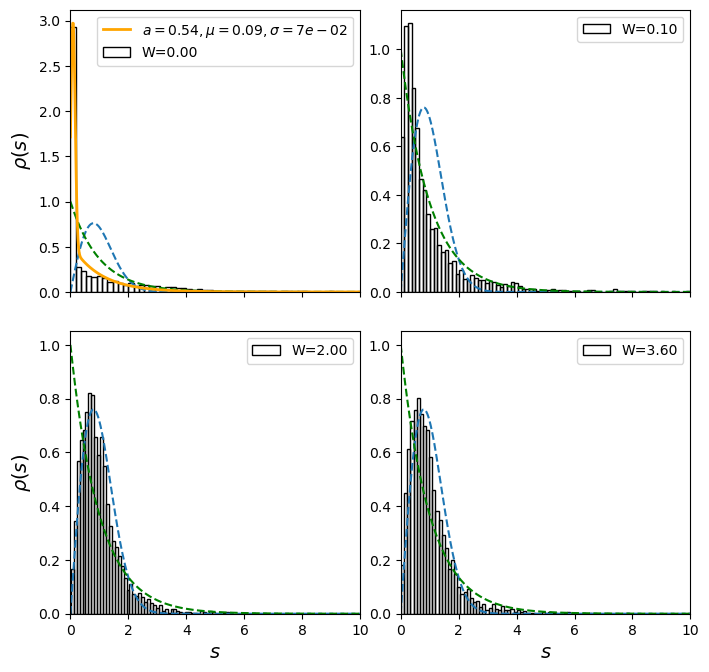

In [101]:
distfigs, distaxes = plt.subplots(2,2,sharex=True,sharey=False,num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
# distfigs, distaxes = plt.subplots(2,4,sharex=True,sharey=True,num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')
s0 = np.linspace(0,20,1000)
for i,ax in enumerate(distaxes.flat):
    dist_data = rho_wd_list[i] # spacing distribution data
    ax.plot(s0,dist_wd(s0),ls='--')
    ax.plot(s0,dist_p(s0),ls='--',color='green')
    
    ## 
    nsamp = len(dist_data) # for ideal bin width 
    bin_width = 2*IQRget(dist_data)/nsamp**(1/3.) # bin width according to Freedman-Draconis rule 
    Nbins = int((np.max(dist_data)-np.min(dist_data))/bin_width) # number of bins in histogram
    print(Nbins)
    # ax.bar(bin_spots,counts/(np.sum(counts)*bin_width),width=bin_width,fill=False,label='W=%.2f'%h_list_mat[i])
    # ax.bar(bin_spots,counts/(nsamp*bin_width),width=bin_width,fill=False,label='W=%.2f'%h_list_mat[i])
    ax.hist(dist_data,bins=Nbins,density=True,fill=False,label='W=%.2f'%h_list_mat[i])
    # ax.hist(dist_data,bins=Nbins,density=False,fill=False,label='W=%.2f'%h_list_mat[i])
    ax.set_xlim(0,10)
    # ax.set_ylim(0,1)
    # ax.legend(loc='upper right',fontsize=14)
    # ax.tick_params(axis="y",direction="in") # puts ticks in the graph
    # ax.tick_params(axis="x",direction="in")
    counts,bin_edges = np.histogram(dist_data,bins=Nbins,density=True)
    bin_spots = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(counts)]
    bin_spots = np.asarray(bin_spots)
    if i==0:
        param,pcov = curve_fit(w0_fitter,bin_spots,counts,p0=[0.90,bin_spots[np.argmax(counts)],1e-3],bounds=([0,bin_spots[0],0],[1,bin_spots[np.argmax(counts)+1],1])) # centers gaussian fit to countmax
        ax.plot(s0,w0_fitter(s0,param[0],param[1],param[2]),color='orange',linewidth=2,label=r'$a=%.2f,\mu=%.2f,\sigma=%.0e$'%(param[0],param[1],param[2]))
        ax.legend(loc='upper right',fontsize=10)
    else:
        param,pcov = curve_fit(wd_fitter,bin_spots,counts,p0=[0.90,bin_spots[np.argmax(counts)],1e-3],bounds=([0,bin_spots[0],0],[1,bin_spots[np.argmax(counts)],1])) # centers gaussian fit to countmax
        # ax.plot(s0,wd_fitter(s0,param[0],param[1],param[2]),color='orange',linewidth=2,label=r'$b=%.2f,\mu=%.2f,\sigma=%.0e$'%(param[0],param[1],param[2]))
        # ax.plot(s0,dist_wd(s0),color='orange',ls='-')
        ax.legend(loc='upper right',fontsize=10)
    

distaxes[0,0].set_ylabel(r'$\rho(s)$',fontsize=14)
distaxes[1,0].set_ylabel(r'$\rho(s)$',fontsize=14)
distaxes[1,0].set_xlabel(r'$s$',fontsize=14)
distaxes[1,1].set_xlabel(r'$s$',fontsize=14)
# distaxes[1,2].set_xlabel(r'$s$',fontsize=14)
# distaxes[1,3].set_xlabel(r'$s$',fontsize=14)
distfigs.subplots_adjust(wspace=0.14,hspace=0.14)
distfigs.savefig('Figures/p_wd_L%i_Sz%i.png'%(L_list_mat[0],Szval),bbox_inches='tight',pad_inches=0.1,dpi=200)

In [172]:
bin_spots

array([ 0.13498117,  0.40494351,  0.67490585,  0.94486819,  1.21483054,
        1.48479288,  1.75475522,  2.02471756,  2.2946799 ,  2.56464224,
        2.83460458,  3.10456693,  3.37452927,  3.64449161,  3.91445395,
        4.18441629,  4.45437863,  4.72434097,  4.99430332,  5.26426566,
        5.534228  ,  5.80419034,  6.07415268,  6.34411502,  6.61407736,
        6.88403971,  7.15400205,  7.42396439,  7.69392673,  7.96388907,
        8.23385141,  8.50381375,  8.7737761 ,  9.04373844,  9.31370078,
        9.58366312,  9.85362546, 10.1235878 , 10.39355014, 10.66351248,
       10.93347483, 11.20343717, 11.47339951, 11.74336185, 12.01332419,
       12.28328653, 12.55324887, 12.82321122, 13.09317356, 13.3631359 ,
       13.63309824, 13.90306058, 14.17302292, 14.44298526, 14.71294761,
       14.98290995, 15.25287229, 15.52283463, 15.79279697, 16.06275931,
       16.33272165, 16.602684  , 16.87264634])

In [260]:
dist_test = rho_wd_list[2]
nsamp = len(dist_test) # for ideal bin width 
bin_width = 2*IQRget(dist_test)/nsamp**(1/3.) # bin width according to Freedman-Draconis rule 
Nbins = int((np.max(dist_test)-np.min(dist_test))/bin_width) # number of bins in histogram
counts,bin_edges = np.histogram(dist_test,bins=Nbins,density=True)
bin_spots = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(counts)]
bin_spots = np.asarray(bin_spots)
bin_spots[0]
bin_spots[np.argmax(counts)]

0.6727809621889376

[0.44000095 0.16664352 0.92257722]


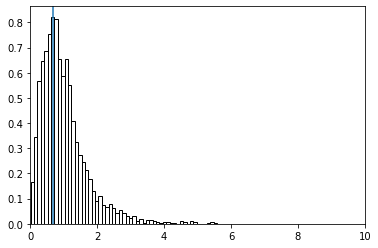

In [262]:
s = np.linspace(0,10,1000)
param,pcov = curve_fit(fitter,bin_spots,counts,p0=[0.90,bin_spots[0],1e-3],bounds=([0,bin_spots[0],0],[0.99,bin_spots[1],1]))
# plt.plot(s,dist_p(s))
# plt.plot(s,fitter(s,0.9,0.05))
# plt.plot(s,fitter(s,param[0],param[1],param[2]))
plt.bar(bin_spots,counts,fill=False,width=bin_width)
plt.xlim(0,10)
plt.axvline(0.6728)
# plt.ylim(0,3)

print(param)

#### Inverse participation ratio, $IPR_2$

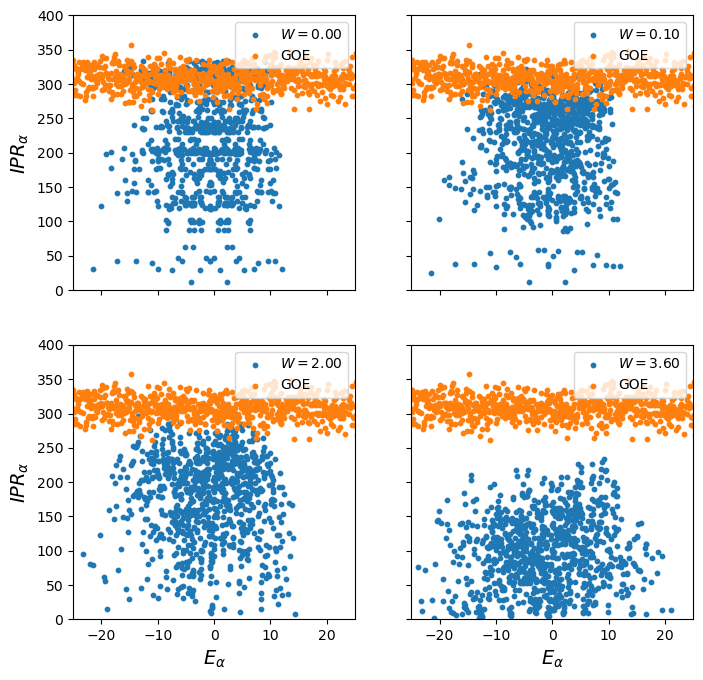

In [96]:
L_list_ipr = [12]
h_list_ipr = [0,0.1,2,3.6]


eval_datalist = []
ipr_datalist = []

for i,lval in enumerate(L_list_ipr):
    for j,hval in enumerate(h_list_ipr):
        eval_data = np.loadtxt('Data/eval_L%i_h%.2f_Sz%i.dat'%(L_list_ipr[0],hval,Szval))
        ipr_data = np.loadtxt('Data/ipr_L%i_h%.2f_Sz%i.dat'%(L_list_ipr[0],hval,Szval))
        eval_datalist.append(eval_data)
        ipr_datalist.append(ipr_data)

ipr_goe = np.loadtxt('Data/ipr_L%i_goe.dat'%(L_list_ipr[0]))
eval_goe = np.loadtxt('Data/eval_L%i_goe.dat'%(L_list_ipr[0]))
iprfigs, ipraxes = plt.subplots(2,2,sharex=True,sharey=True,num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
for k,ax in enumerate(ipraxes.flat):
    ax.scatter(eval_datalist[k],ipr_datalist[k],label=r'$W=%.2f$'%h_list_ipr[k],s=10)
    ax.scatter(eval_goe,ipr_goe,label='GOE',s=10)
    ax.set_ylim(0,400)
    ax.set_xlim(-25,25)
    ax.legend(loc='upper right')

ipraxes[0,0].set_ylabel(r'$IPR_\alpha$',fontsize=14)
ipraxes[1,0].set_ylabel(r'$IPR_\alpha$',fontsize=14)
ipraxes[1,0].set_xlabel(r'$E_\alpha$',fontsize=14)
ipraxes[1,1].set_xlabel(r'$E_\alpha$',fontsize=14)
iprfigs.savefig('Figures/ipr_L%i.png'%L_list_ipr[0],pad_inches=0.005,dpi=100)

#### Observable matrix elements in eigenbasis

In [19]:
## s_{L/2}^z matrix in eigenbasis
L_list_mat = [12] # uncomment this line and next for various L
# h_list_mat = [0,0.1,1,3]
# h_list_mat = [i for i in np.arange(0,3,0.8)]
h_list_mat = [0,0.1,2,3.6]
delta = 1
Szval = 0

# loads files
szhalf_mat_filelist = []
eval_filelist = []

for i,lval in enumerate(L_list_mat):
    for j,hval in enumerate(h_list_mat):
        szhalf_mat_filelist.append('Data/szhalf_mat_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval))
        eval_filelist.append('Data/eval_L%i_h%.2f_Sz%i.dat'%(lval,hval,Szval))
# print(szhalf_mat_filelist)

# loads to list
pic_list = []
for i,matval in enumerate(szhalf_mat_filelist):
    picmat = np.loadtxt(matval) # loads unsliced szhalf mat. will get a 50 by 50 sector centered around the average eigval.
    # L_temp = len(picmat) # since different L may be considered for comparison. Minimum L=8 as 8C4 = 70. 6C3 = 20 < 50 (size of sector)
    
    ## sectoring algorithm 
    # finds 50 x 50 sector centered around the eigenvalue closest to the average (typically at D//2).
    eval_list = np.loadtxt(eval_filelist[i]) # loads eigval list
    nearestval = find_nearest(eval_list,np.mean(eval_list)) # finds value in eval_list closest to average
    sc = np.where(eval_list==nearestval)[0][0] # finds sector center (sc) index of nearestval in eval_list. indices due to formatting of np.where.
    picmat_sec = picmat[sc-25:sc+25,sc-25:sc+25] # gets slice of szhalf centered around sc
    # picmat_sec = picmat[L_temp//2-25:L_temp//2+25,L_temp//2-25:L_temp//2+25] # change range for specific locations
    # pic_list.append(picmat_sec)
    pic_list.append(picmat_sec)

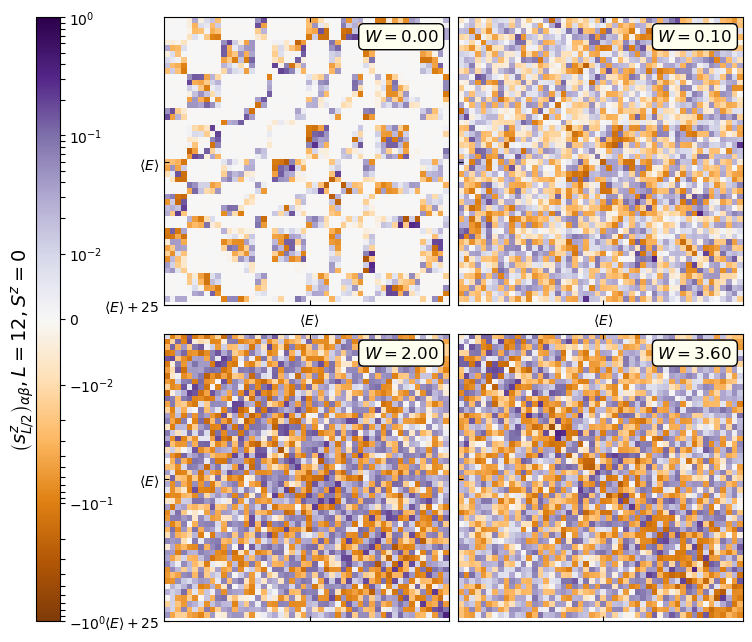

In [21]:
# generates subplots
matfigs, axes = plt.subplots(2,2,sharex=True,sharey=True,num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k') # 4 subplots
# matfigs, axes = plt.subplots(2,3,sharex=True,sharey=True,num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k') # 6 subplots
data_list = []
symlognorm = col.SymLogNorm(linthresh=0.01, base=10, linscale=0.5,vmin=-1,vmax=1) # converts colormap to symmetric log
for i,ax in enumerate(axes.flat):
    A = pic_list[i] # operator matrix
    # ax.imshow(A,cmap='PuOr',vmin=np.min(pic_list),vmax=np.max(pic_list),norm=norm)
    # ax.imshow(A,cmap='PuOr',vmin=np.min(pic_list),vmax=np.max(pic_list))
    ax.matshow(A,cmap='PuOr',norm=symlognorm)
    # ax.set_xlabel(subfig_list[i],fontsize=14)
    ax.tick_params(axis="y",direction="in") # puts ticks in the graph
    ax.tick_params(axis="x",direction="in")
    data_list.append(matstats(A,1))
    props = dict(boxstyle='round', facecolor='ivory')
    # ax.text(0.315,.96,r'$W=%.2f, \langle E\rangle=%.1e$'%(h_list_mat[i],data_list[i][0]),fontsize=10,transform=ax.transAxes,
        # verticalalignment='top', bbox=props,size=12)
    ax.text(0.7,.96,r'$W=%.2f$'%(h_list_mat[i]),fontsize=10,transform=ax.transAxes,
        verticalalignment='top', bbox=props,size=12)
    # ax.text(1,10,r'$E_0=%.1e$'%data_list[i][0],fontsize=14)
# np.savetxt('Data/offdiagstats_L%i_Sz%i.dat'%(L_list_mat[0],Szval),data_list)
    
axes[0,0].set_xticks(ticks=[len(picmat_sec)//2])
axes[0,0].set_xticklabels([r'$\langle E\rangle$']) # values only work for L=12, at middle 50% of matrix
axes[0,0].set_yticks(ticks=[len(picmat_sec)//2,len(picmat_sec)])
axes[0,0].set_yticklabels([r'$\langle E\rangle$',r'$\langle E\rangle+25$'])

norm = col.Normalize(vmin=np.min(pic_list),vmax=np.max(pic_list)) # fixes the normalization of the color plots
# norm = col.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-0.5,0.5, base=10)
cax = matfigs.add_axes([-0.01,0.125,0.03,0.755]) # [hori-offset,vert,width,height], for 4 subplots
# cax = matfigs.add_axes([-0.04,0.15,0.03,0.7]) # for 6 subplots
cbar = matfigs.colorbar(cm.ScalarMappable(cmap='PuOr',norm=symlognorm),cax=cax)
# cbar = matfigs.colorbar(cm.ScalarMappable(cmap='PuOr',norm=norm),orientation='horizontal',pad=0.2)
# cbar = matfigs.colorbar(cm.ScalarMappable(cmap='PuOr',norm=norm))
cbar.set_label(r'$\left(s_{L/2}^z\right)_{\alpha\beta},L=%i,S^z=%i$'%(L_list_mat[0],Szval),fontsize='14',labelpad=-75, y=0.45) # 4
# cbar.set_label(r'$\left(s_{L/2}^z\right)_{\alpha\beta},L=%i,S^z=%i$'%(L_list_mat[0],Szval),fontsize='14',labelpad=-65, y=0.45) # 6 
# matfigs.subplots_adjust(wspace=0.1,hspace=0) # for 6 subplots
matfigs.subplots_adjust(wspace=-0.1,hspace=0.1) # for 4 subplots 
matfigs.savefig('Figures/szhalf_mat_L%i_Sz%i.png'%(L_list_mat[0],Szval),bbox_inches='tight',pad_inches=0.05,dpi=200)

#### $\langle s_{L/2}^z \rangle$ for different L

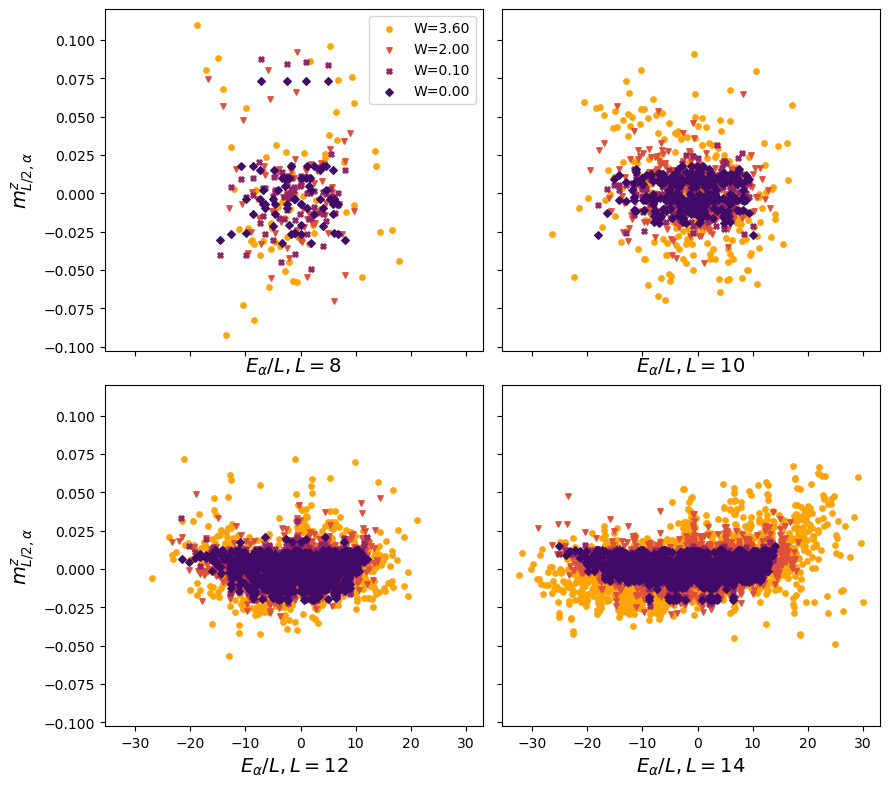

In [26]:
L_list_hvar = [8,10,12,14]
# hexpec_list_hvar = [i for i in np.arange(0,3.2,0.8)]
hexpec_list_hvar = [3.6,2,0.1,0]

szhalf_filelist_hvar = []
# szhalfmat_filelist_hnot0 = []
eval_filelist_hvar = []
for k,lval in enumerate(L_list_hvar):
    szhalf_filelist_hvar.append([])
    eval_filelist_hvar.append([])
    for i in range(len(hexpec_list_hvar)):
        szhalf_filelist_hvar[k].append('Data/expec_spin_z_half_L%i_h%.2f_Sz%i.dat'%(lval,hexpec_list_hvar[i],Szval))
        eval_filelist_hvar[k].append('Data/eval_L%i_h%.2f_Sz%i.dat'%(lval,hexpec_list_hvar[i],Szval))

expechvarfigs,axes = plt.subplots(2,2,sharex=True,sharey=True,num=None, figsize=(10, 9.5), dpi=100, facecolor='w', edgecolor='k')

for k,ax in enumerate(axes.flat):
    for i,ll in enumerate(szhalf_filelist_hvar[k]):
        x = np.loadtxt(eval_filelist_hvar[k][i])
        y = np.loadtxt(szhalf_filelist_hvar[k][i])
        ax.scatter(x,y,label='W=%.2f'%(hexpec_list_hvar[i]),marker=mlist[i],s=15,color=cm.inferno(0.8-0.8*i/len(L_list_hvar)))
        ax.set_xlabel(r'$E_\alpha/L,L=%i$'%L_list_hvar[k],fontsize='14')
        if k==0 or k==len(axes.flat)//2:
            ax.set_ylabel(r'$m_{L/2,\alpha}^{z}$',fontsize='14')
            if k==0:
                ax.legend()
        else:
            continue
    
expechvarfigs.subplots_adjust(wspace=0.05,hspace=0.1) # for 4 subplots 
plt.savefig('Figures/shalf_vs_eigvalsite_hvar.png',bbox_inches='tight',pad_inches=0.1,dpi=200)

#### (Defunct) $\sigma^2(s_{L/2}^z)$ vs. $L$ for different W

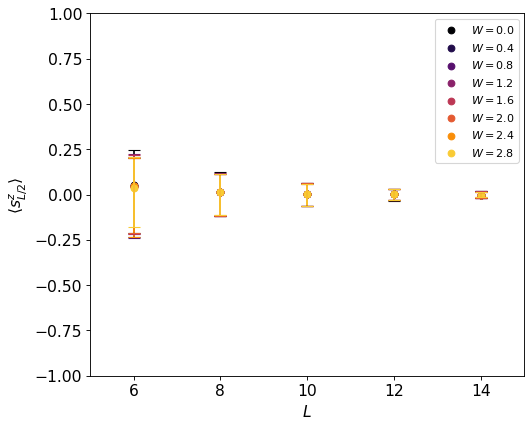

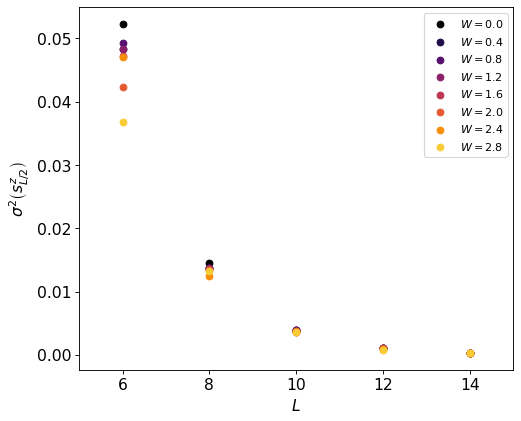

In [ ]:
## Plots var(s_{L/2}^z) as a function of system sizes for different disorder parameter strengths 

L_list_stattest = [6,8,10,12,14]
h_list_stattest = [i for i in np.arange(0,3.2,0.4)]
offdiagstats_filelist = []
Szval = 0

fshalfl_m = plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
for i,hval in enumerate(h_list_stattest):
    offdiag_array = np.loadtxt('Data/offdiagstats_h%.2f_Sz%i.dat'%(hval,Szval))
    meanlist,varlist = offdiag_array[:,0],offdiag_array[:,1]
    # plt.errorbar(L_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',label=r'$W=%.1f$'%hval)
    plt.errorbar(L_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',color=cm.inferno(i/len(h_list_stattest)))
    plt.scatter(L_list_stattest,varlist,label=r'$W=%.1f$'%hval,color=cm.inferno(i/len(h_list_stattest)))
    # plt.scatter(L_list_stattest,meanlist)
# plt.plot(L_list_stattest,errlist)
plt.xlim(5,15)
plt.xlabel(r'$L$',fontsize=14)
plt.ylim(-1,1)
plt.ylabel(r'$\langle s_{L/2}^z \rangle $',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('Figures/offdiagmean_vs_L.png',bbox_inches='tight',pad_inches=0.05,dpi=200)

fshalfl_v = plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
for i,hval in enumerate(h_list_stattest):
    offdiag_array = np.loadtxt('Data/offdiagstats_h%.2f_Sz%i.dat'%(hval,Szval))
    meanlist,varlist = offdiag_array[:,0],offdiag_array[:,1]
    # plt.errorbar(L_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',label=r'$W=%.1f$'%hval)
    # plt.errorbar(L_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',color=cm.inferno(i/len(h_list_stattest)))
    plt.scatter(L_list_stattest,varlist,label=r'$W=%.1f$'%hval,color=cm.inferno(i/len(h_list_stattest)))
    # plt.scatter(L_list_stattest,meanlist)
# plt.plot(L_list_stattest,errlist)
plt.xlim(5,15)
plt.xlabel(r'$L$',fontsize=14)
plt.ylabel(r'$\sigma^2\left(s_{L/2}^z\right)$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('Figures/offdiagvar_vs_L.png',bbox_inches='tight',pad_inches=0.05,dpi=200)

In [ ]:
offdiag_array[::2]

array([[ 0.01814994,  0.05230216],
       [-0.01581269,  0.04831129],
       [-0.0169572 ,  0.04923451],
       [ 0.00403689,  0.04828178],
       [ 0.00126994,  0.04721451],
       [-0.00462941,  0.04235719],
       [-0.01759351,  0.04702828],
       [ 0.01340294,  0.03677957]])

#### (Defunct) $\sigma^2(s_{L/2}^z)$ vs. $W$ for different L

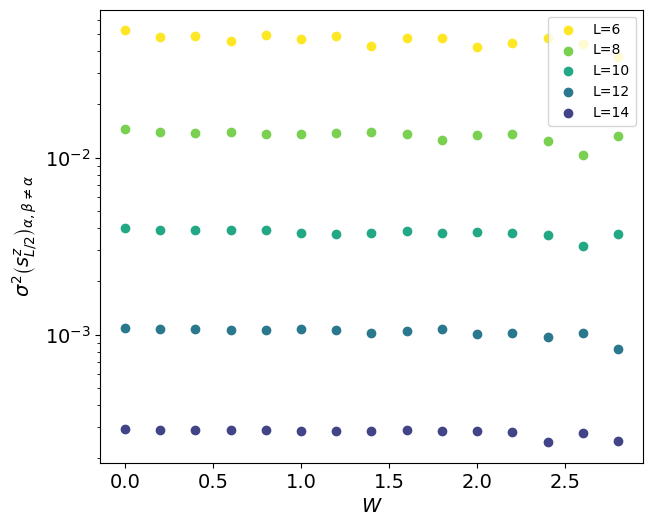

In [9]:
## Plots <s_{L/2}^z> as a function of disorder parameter h

Szval = 0
# fshalfh = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
L_list_stattest = [6,8,10,12,14]
h_list_stattest = [i for i in np.arange(0,3,0.2)]

fshalfh = plt.figure(num=None, figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
for i,lval in enumerate(L_list_stattest):
    offdiag_array = np.loadtxt('Data/offdiagstats_L%i_Sz%i.dat'%(lval,Szval))
    meanlist,varlist = offdiag_array[:,0],offdiag_array[:,1] # vary this to not get the full list 
    # plt.errorbar(L_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',label=r'$W=%.1f$'%hval)
    # plt.errorbar(h_list_stattest,meanlist,yerr=np.sqrt(varlist),capsize=5,fmt='none',color=cm.viridis(1-i/len(L_list_stattest)))
    # plt.scatter(h_list_stattest,varlist,label=r'$L=%i$'%lval,color=cm.viridis(1-i/len(L_list_stattest)))
    plt.scatter(h_list_stattest,varlist,label=r'L=%i'%lval,color=cm.viridis(1-i/len(L_list_stattest)))
plt.ylabel(r'$\sigma^2\left( s_{L/2}^z\right)_{\alpha,\beta\neq\alpha}$',fontsize=14)
# plt.ylim(-1e-4,1e-4)
plt.yscale('log') # if this is on, it won't present the negative values. expect less data points. unless we use np.abs.
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$W$',fontsize=14)
plt.legend()
# plt.legend(fontsize='14')
plt.savefig('Figures/szhalfmat_vs_h_Sz%i.png'%(Szval),bbox_inches='tight',pad_inches=0.05,dpi=200)

#### (Defunct) $\langle s_{L/2}^z \rangle$ for different L

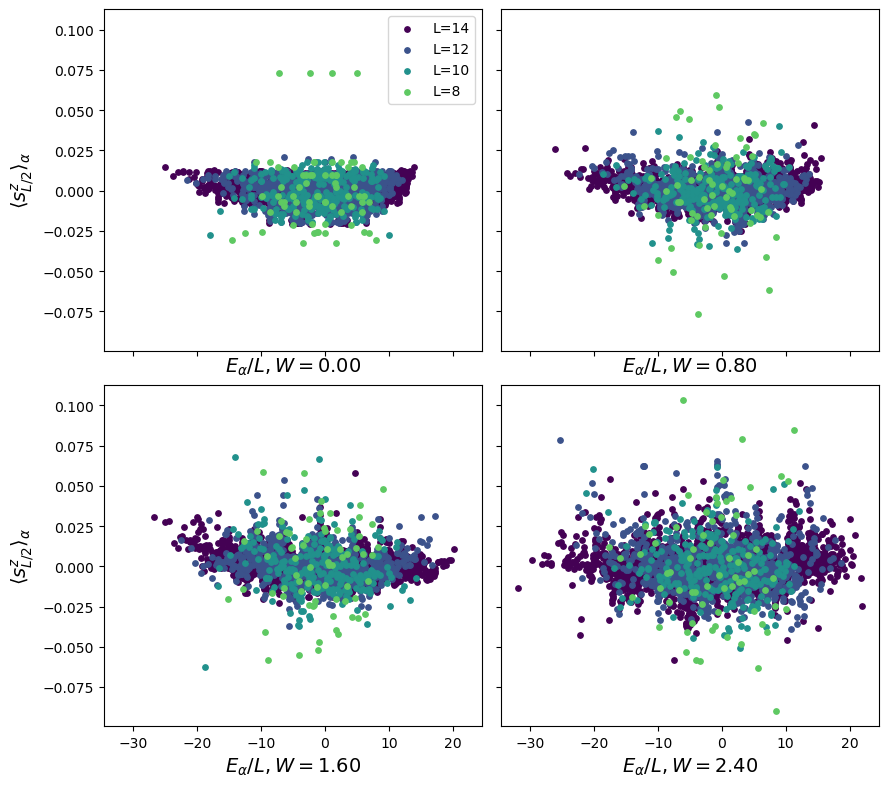

In [ ]:
## Plots expectation value of spinz at site L/2 for different L sizes
Llist = [14,12,10,8]
hexpec_list_lvar = [i for i in np.arange(0,3.2,0.8)]

szhalf_filelist_lvar = []
# szhalfmat_filelist_hnot0 = []
eval_filelist_lvar = []
for k,hval in enumerate(hexpec_list_lvar):
    szhalf_filelist_lvar.append([])
    # szhalfmat_filelist_hnot0 = []
    eval_filelist_lvar.append([])
    for i in range(len(Llist)):
        szhalf_filelist_lvar[k].append('Data/expec_spin_z_half_L%i_h%.2f_Sz%i.dat'%(Llist[i],hval,Szval))
        eval_filelist_lvar[k].append('Data/eval_L%i_h%.2f_Sz%i.dat'%(Llist[i],hval,Szval))

expeclvarfigs,axes = plt.subplots(2,2,sharex=True,sharey=True,num=None, figsize=(10, 9.5), dpi=100, facecolor='w', edgecolor='k')

for k,ax in enumerate(axes.flat):
    for i,ll in enumerate(szhalf_filelist_lvar[k]):
        x = np.loadtxt(eval_filelist_lvar[k][i])
        y = np.loadtxt(szhalf_filelist_lvar[k][i])
        ax.scatter(x,y,label='L=%i'%(Llist[i]),s=15,color=cm.viridis(i/len(hexpec_list_lvar)))
        ax.set_xlabel(r'$E_\alpha/L,W=%.2f$'%hexpec_list_lvar[k],fontsize='14')
        if k==0 or k==len(axes.flat)//2:
            ax.set_ylabel(r'$\langle s_{L/2}^z \rangle_{\alpha}$',fontsize='14')
            if k==0:
                ax.legend()
        else:
            continue
    
expeclvarfigs.subplots_adjust(wspace=0.05,hspace=0.1) # for 4 subplots 
plt.savefig('Figures/shalf_vs_eigvalsite_lvar.png',bbox_inches='tight',pad_inches=0.05,dpi=200)

In [ ]:
h_list_mat_log = [i for i in np.arange(0,1,0.1)]
h_list_mat_log = h_list_mat_log + [i for i in np.arange(1,3.2,0.2)]
h_list_mat_log = h_list_mat_log + [5,7,9]
h_list_mat_log

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0,
 1.2,
 1.4,
 1.5999999999999999,
 1.7999999999999998,
 1.9999999999999998,
 2.1999999999999997,
 2.3999999999999995,
 2.5999999999999996,
 2.8,
 2.9999999999999996,
 5,
 7,
 9]

#### Spacing indicator

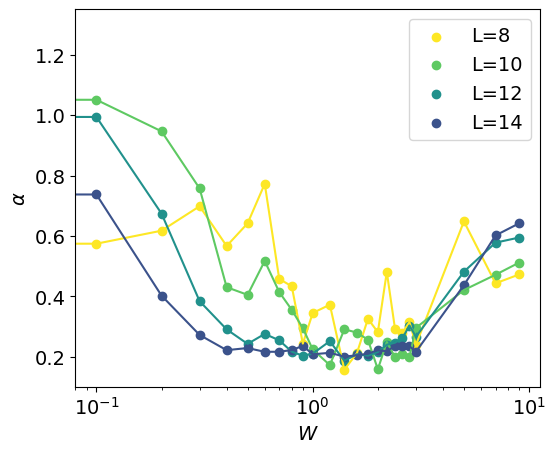

In [ ]:
## Level spacing indicator. Make sure to plot in logscale to see the integrable -> ergodic -> MBL transition 
L_list_mat = [8,10,12,14]
h_list_mat = [i for i in np.arange(0,3,0.2)]

# h_list_mat = [0]
rho_wd_list = []

ftest = plt.figure(num=None, figsize=(6, 5), dpi=100, facecolor='w', edgecolor='k')
# shape of subplots depends on len(L_list_mat)
# alffigs, alfaxes = plt.subplots(1,3,sharex=True,sharey=True,num=None, figsize=(13, 4), dpi=100, facecolor='w', edgecolor='k')
# for i,ax in enumerate(alfaxes.flat):
for i,lval in enumerate(L_list_mat):
    alfie_list = []
    rho_wd_list = []
    for j,hval in enumerate(h_list_mat_log):
        # print(i,j)
        eval_ord = np.loadtxt('Data/eval_L%i_h%.2f_Sz%i.dat'%(L_list_mat[i],hval,Szval))
        # print('Data/eval_L%i_h%.2f_Sz%i.dat'%(L_list_mat[i],hval,Szval))
        rho_wd_list.append(dist_spacing(pctl_cutoff(eval_ord,5))) 
        dist_data = rho_wd_list[j]
        
        nsamp = len(dist_data)
        bin_width = 2*IQRget(dist_data)/nsamp**(1/3.)
        Nbins = int((np.max(dist_data)-np.min(dist_data))//bin_width)
        pwdvals,bin_edges = np.histogram(dist_data,bins=Nbins,density=True)
        m = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(pwdvals)] # positions of bins a.k.a. comparison values m in discrete sum
        # print(len(m),len(pwdvals))
        
        # calculates level spacing indicator alpha
        alfie = 0 # alpha variable
        alfie_norm = 0
        for k,pval in enumerate(pwdvals):
            alfie += np.abs(pval-dist_wd(m[k]))
            alfie_norm += dist_wd(m[k])
        alfie = alfie/alfie_norm
        alfie_list.append(alfie)
    # plt.plot(h_list_mat,alfie_list,label='L=%i'%L_list_mat[i],color=cm.viridis(1-i/len(L_list_mat)))
    plt.plot(h_list_mat_log,alfie_list,color=cm.viridis(1-i/len(L_list_mat)))
    plt.scatter(h_list_mat_log,alfie_list,label='L=%i'%L_list_mat[i],color=cm.viridis(1-i/len(L_list_mat)))
    plt.legend(fontsize=14)
    # plt.xlim(0,10)
    plt.xlabel(r'$W$',fontsize=14)
    plt.ylabel(r'$\alpha$',fontsize=14)
    plt.xticks(fontsize=14)
    plt.xscale('log')
    plt.yticks(fontsize=14)
plt.savefig('Figures/spacing_indicator_v_h.png',bbox_inches='tight',pad_inches=0.05,dpi=200)


### Random matrices and Gaussian Orthogonal Ensembles (GOE)

In [102]:
## Generates a matrix sampled from GOE with dimension (2**L,2**L), L as chain size
## process done from Santos2014, with guidance from Livan2017
L_goe = 12
D = comb(L_goe,L_goe//2)
# h_asym = np.random.normal(0,1,size=(2**L_goe,2**L_goe))
h_asym = np.random.normal(0,1,size=(D,D))
h_sym = 0.5*(h_asym+h_asym.transpose()) # Livan2017 has 0.5 factor, Santos2014 does not

eig_sym,eigvec_sym = eigensolver(h_sym) # eigspec of symmetrized matrix

print('Diagonal element variance = %.3f; off-diagonal element variance = %.3f.' %(matstats(h_sym,1)[1],matstats(h_sym,0)[1]))

Diagonal element variance = 1.052; off-diagonal element variance = 0.500.


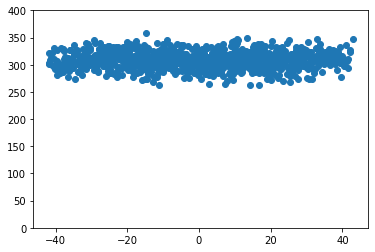

In [104]:
IPR_GOE = IPR_array(eigvec_sym)
plt.scatter(eig_sym,IPR_GOE)
plt.ylim(0,400)
np.savetxt('Data/eval_L%i_goe.dat'%L_goe,eig_sym)
np.savetxt('Data/ipr_L%i_goe.dat'%L_goe,IPR_GOE)

In [106]:
print(gapratio(eig_sym))

314
[1.17489302 0.65751646 1.2824697  1.01264184 1.09259977 0.74794304 1.12224288 1.15555307 0.53416759 1.8412909  0.47586081 2.12152184 1.24812063 0.06362328 2.00858332 0.79003787 1.25248844 0.15402641
 0.6606286  0.76890616 0.88924315 1.66386821 1.07522408 0.34803346 1.11336013 0.73422041 0.93750819 0.87059508 2.08203033 0.64690026 1.09032597 0.15925594 1.07725769 0.96769492 1.80080561 0.52728983
 1.60763475 0.97634338 1.18615722 0.74663916 0.93449134 1.36483265 0.80757657 0.79092633 0.31094856 0.59333523 0.28345734 1.85542887 1.85221466 0.45729704 1.63573287 1.65712087 1.77308923 0.86185109
 0.14387251 0.35474214 1.52251858 0.95504654 1.6780503  0.7003498  0.40372235 1.18132179 2.20514711 0.69928621 0.45048228 0.24222547 2.00078123 0.98699411 0.86741135 2.57101115 0.85785703 1.13176177
 1.09372135 0.29583007 0.89415059 0.32200781 0.53107288 0.49577285 0.69142091 1.81443531 0.67692192 0.9728549  0.91049853 1.59727908 0.91599618 0.35338965 1.50731463 0.57146493 1.29707021 0.0783997
 1

There are 39 bins, with a level spacing indicator of 0.08.


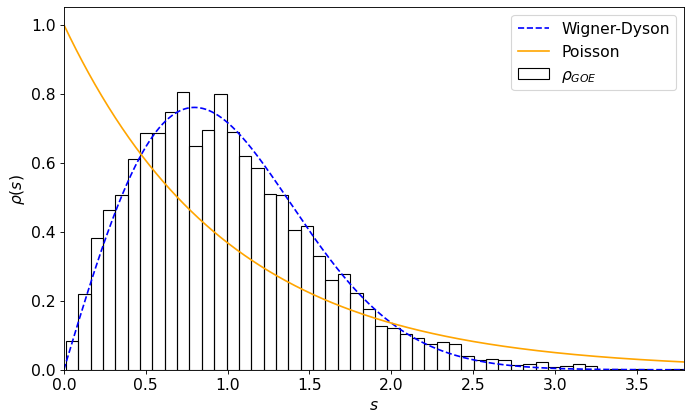

In [ ]:
rho_goe_expec = pctl_cutoff(eig_sym,5)
rho_goe_expec = dist_spacing(rho_goe_expec)
s2 = np.linspace(0,max(rho_goe_expec),1000)

g = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

nsamp = len(rho_goe_expec)
bin_width = 2*IQRget(rho_goe_expec)/nsamp**(1/3.)
Nbins = int((np.max(rho_goe_expec)-np.min(rho_goe_expec))//bin_width)
pwdvals,bin_edges = np.histogram(rho_goe_expec,bins=Nbins,density=True)
m = [(bin_edges[i+1]+bin_edges[i])/2 for i,val in enumerate(pwdvals)] # positions of bins a.k.a. comparison values m in discrete sum
# print(len(m),len(pwdvals))

# calculates level spacing indicator alpha
alfie = 0 # alpha variable
alfie_norm = 0
for k,pval in enumerate(pwdvals):
    alfie += np.abs(pval-dist_wd(m[k]))
    alfie_norm += dist_wd(m[k])
    # print(alfie,alfie_norm)
alfie = alfie/alfie_norm

plt.hist(rho_goe_expec,density=True,bins=50,label=r'$\rho_{GOE}$',fill=False)
plt.plot(s2,dist_wd(s2),c='b',ls='--',label='Wigner-Dyson')
plt.plot(s2,dist_p(s2),c='orange',ls='-',label='Poisson')
plt.xlim(0,max(rho_goe_expec))
plt.xlabel(r'$s$',fontsize='14')
plt.ylabel(r'$\rho(s)$',fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.legend(fontsize='14')
# plt.savefig('Figures/wd_goe_L%i.png'%L_goe,bbox_inches='tight',pad_inches=0.05,dpi=200)
print('There are %i bins, with a level spacing indicator of %.2f.'%(Nbins,alfie))
# plt.title('Level-spacing distribution of GOE matrix',fontsize='14')